In [159]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics import mean_absolute_error as mae
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import RFE
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error
import xgboost as xgb
import pandas as pd
from sklearn.metrics import make_scorer


#  1. Load Data and Delete duplicates

In [115]:

def delete_rows_with_same_values(df, columns_to_check):
    X = df.copy()  # Make a copy of the DataFrame to avoid modifying the original
    X.sort_values(by="ddG", ascending=False)
    # Identify rows where specified columns have the same value
    rows_to_delete = X.duplicated(subset=columns_to_check, keep='first') 

    # Invert the boolean mask to keep rows that don't have the same values in specified columns
    X_filtered = X[~rows_to_delete]

    return X_filtered

columns_to_check_for_duplicates = ['starting electrophile SMILES', 'nucleophile SMILES',
        '3,3 Catalyst Substituent ', 'Temperature (Kelvin)', 
        'N Catalyst Substituent']

In [116]:
result = pd.read_csv("../Data/merged_max.csv")
result = delete_rows_with_same_values(result, columns_to_check_for_duplicates)
result.to_csv("../Data/clean_merged_max.csv")
result= pd.read_csv("../Data/clean_merged_max.csv")#Relod to recount rows

# 2. Load RDKit Descrciptors

In [117]:
from functions.common_functions import *

electrophileSMILES = result['input electrophile SMILES'].values
electrophiledescriptors = smi2RDKIT(electrophileSMILES)
nucleophileSMILES = result['nucleophile SMILES'].values
nucleophiledescriptors = smi2RDKIT(nucleophileSMILES)
threethreesubSMILES = result['3,3 Catalyst Substituent '].values
threethreesubdescriptors = smi2RDKIT(threethreesubSMILES)


# 3. Data Engineering

In [118]:
T = result.loc[:,['Temperature (Kelvin)', '3,3 Catalyst Substituent ','input electrophile SMILES', 'nucleophile SMILES', 'starting electrophile SMILES', 'N Catalyst Substituent']]

ddg= result.loc[:,'ddG']

T['Ncat_alif'] = T['N Catalyst Substituent'].apply(lambda x: 1 if x == 'NS(=O)(=O)C(F)(F)F' else (2 if x == 'NS(=O)(=O)C(F)(F)C(F)(F)F' else (4 if x == 'NS(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F' else ( 6 if x == 'NS(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F' else 0))))
T['Ncat_arom'] = T['N Catalyst Substituent'].apply(lambda x: 1 if x == 'NS(=O)(=O)c1c(F)c(F)c(F)c(F)c1F' else 0)

ddg


0      1.231712
1      1.066407
2      1.002518
3      0.896691
4      1.033884
         ...   
318    1.338303
319    1.338303
320    1.092856
321    1.195347
322    0.537292
Name: ddG, Length: 323, dtype: float64

In [119]:
from sklearn.feature_selection import VarianceThreshold

def feature_reducer(df):
    X = df.copy()  # Make a copy of the DataFrame to avoid modifying the original
    
    # Apply VarianceThreshold
    VT = VarianceThreshold()
    descriptors = VT.fit_transform(X)
    
    # Get the columns that are retained by VarianceThreshold
    columns_after_variance_threshold = X.columns[VT.get_support()]
    
    # Create a DataFrame after VarianceThreshold
    X_filtered = X[columns_after_variance_threshold]    

    return X_filtered



alldescriptors = electrophiledescriptors.join(nucleophiledescriptors, lsuffix='electrophile', rsuffix='nucleophile').join(threethreesubdescriptors, rsuffix='threethreesubdescriptors')
alldescriptors = feature_reducer(alldescriptors)
alldescriptors

,MaxAbsEStateIndexelectrophile,MaxEStateIndexelectrophile,MinAbsEStateIndexelectrophile,MinEStateIndexelectrophile,qedelectrophile,MolWtelectrophile,HeavyAtomMolWtelectrophile,ExactMolWtelectrophile,NumValenceElectronselectrophile,MaxPartialChargeelectrophile,...,NumSaturatedRings,RingCount,MolLogP,MolMR,fr_alkyl_halide,fr_aryl_methyl,fr_benzene,fr_bicyclic,fr_halogen,fr_unbrch_alkane
0,10.450170,10.450170,0.730278,0.730278,0.579913,156.184,148.120,156.057515,58.0,0.149570,...,0.0,2.0,2.8398,43.948,0.0,0.0,2.0,1.0,0.0,0.0
1,10.548588,10.548588,0.696914,0.696914,0.673793,186.210,176.130,186.068080,70.0,0.149570,...,0.0,2.0,2.8398,43.948,0.0,0.0,2.0,1.0,0.0,0.0
2,10.507847,10.507847,0.717428,0.717428,0.691883,235.080,228.024,233.968027,64.0,0.149570,...,0.0,2.0,2.8398,43.948,0.0,0.0,2.0,1.0,0.0,0.0
3,10.006481,10.006481,0.729167,0.729167,0.495636,106.124,100.076,106.041865,40.0,0.149548,...,0.0,2.0,2.8398,43.948,0.0,0.0,2.0,1.0,0.0,0.0
4,12.358704,12.358704,0.108796,-0.465278,0.519899,124.114,119.074,124.032443,46.0,0.152494,...,0.0,3.0,3.4522,59.286,0.0,2.0,2.0,3.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318,9.826481,9.826481,0.821759,0.821759,0.377957,98.145,88.065,98.073165,40.0,0.144920,...,0.0,3.0,3.9930,61.454,0.0,0.0,3.0,3.0,0.0,0.0
319,10.091620,10.091620,0.971389,0.971389,0.469249,110.156,100.076,110.073165,44.0,0.145202,...,0.0,3.0,3.9930,61.454,0.0,0.0,3.0,3.0,0.0,0.0
320,9.667593,9.667593,0.787037,0.787037,0.343827,84.118,76.054,84.057515,34.0,0.144910,...,0.0,3.0,3.9930,61.454,0.0,0.0,3.0,3.0,0.0,0.0
321,9.938843,9.938843,0.951389,0.951389,0.449462,96.129,88.065,96.057515,38.0,0.145202,...,0.0,3.0,3.9930,61.454,0.0,0.0,3.0,3.0,0.0,0.0


In [120]:

unique_counts = alldescriptors.nunique()

# Get the column names where there is more than one unique value
cols_to_keep = unique_counts[unique_counts > 1].index

# Create a new DataFrame with only the selected columns
result_df = alldescriptors[cols_to_keep]
result_df

,MaxAbsEStateIndexelectrophile,MaxEStateIndexelectrophile,MinAbsEStateIndexelectrophile,MinEStateIndexelectrophile,qedelectrophile,MolWtelectrophile,HeavyAtomMolWtelectrophile,ExactMolWtelectrophile,NumValenceElectronselectrophile,MaxPartialChargeelectrophile,...,NumSaturatedRings,RingCount,MolLogP,MolMR,fr_alkyl_halide,fr_aryl_methyl,fr_benzene,fr_bicyclic,fr_halogen,fr_unbrch_alkane
0,10.450170,10.450170,0.730278,0.730278,0.579913,156.184,148.120,156.057515,58.0,0.149570,...,0.0,2.0,2.8398,43.948,0.0,0.0,2.0,1.0,0.0,0.0
1,10.548588,10.548588,0.696914,0.696914,0.673793,186.210,176.130,186.068080,70.0,0.149570,...,0.0,2.0,2.8398,43.948,0.0,0.0,2.0,1.0,0.0,0.0
2,10.507847,10.507847,0.717428,0.717428,0.691883,235.080,228.024,233.968027,64.0,0.149570,...,0.0,2.0,2.8398,43.948,0.0,0.0,2.0,1.0,0.0,0.0
3,10.006481,10.006481,0.729167,0.729167,0.495636,106.124,100.076,106.041865,40.0,0.149548,...,0.0,2.0,2.8398,43.948,0.0,0.0,2.0,1.0,0.0,0.0
4,12.358704,12.358704,0.108796,-0.465278,0.519899,124.114,119.074,124.032443,46.0,0.152494,...,0.0,3.0,3.4522,59.286,0.0,2.0,2.0,3.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318,9.826481,9.826481,0.821759,0.821759,0.377957,98.145,88.065,98.073165,40.0,0.144920,...,0.0,3.0,3.9930,61.454,0.0,0.0,3.0,3.0,0.0,0.0
319,10.091620,10.091620,0.971389,0.971389,0.469249,110.156,100.076,110.073165,44.0,0.145202,...,0.0,3.0,3.9930,61.454,0.0,0.0,3.0,3.0,0.0,0.0
320,9.667593,9.667593,0.787037,0.787037,0.343827,84.118,76.054,84.057515,34.0,0.144910,...,0.0,3.0,3.9930,61.454,0.0,0.0,3.0,3.0,0.0,0.0
321,9.938843,9.938843,0.951389,0.951389,0.449462,96.129,88.065,96.057515,38.0,0.145202,...,0.0,3.0,3.9930,61.454,0.0,0.0,3.0,3.0,0.0,0.0


In [121]:
alldesc = pd.concat([result_df ,T], axis=1)

alldesc

,MaxAbsEStateIndexelectrophile,MaxEStateIndexelectrophile,MinAbsEStateIndexelectrophile,MinEStateIndexelectrophile,qedelectrophile,MolWtelectrophile,HeavyAtomMolWtelectrophile,ExactMolWtelectrophile,NumValenceElectronselectrophile,MaxPartialChargeelectrophile,...,fr_halogen,fr_unbrch_alkane,Temperature (Kelvin),"3,3 Catalyst Substituent",input electrophile SMILES,nucleophile SMILES,starting electrophile SMILES,N Catalyst Substituent,Ncat_alif,Ncat_arom
0,10.450170,10.450170,0.730278,0.730278,0.579913,156.184,148.120,156.057515,58.0,0.149570,...,0.0,0.0,195.15,c2ccc1ccccc1c2,O=Cc2ccc1ccccc1c2,C=CC[Si](C)(C)C,O=Cc2ccc1ccccc1c2,NS(=O)(=O)C(F)(F)F,1,0
1,10.548588,10.548588,0.696914,0.696914,0.673793,186.210,176.130,186.068080,70.0,0.149570,...,0.0,0.0,195.15,c2ccc1ccccc1c2,COc2ccc1cc(C=O)ccc1c2,C=CC[Si](C)(C)C,COc2ccc1cc(C=O)ccc1c2,NS(=O)(=O)C(F)(F)F,1,0
2,10.507847,10.507847,0.717428,0.717428,0.691883,235.080,228.024,233.968027,64.0,0.149570,...,0.0,0.0,195.15,c2ccc1ccccc1c2,O=Cc2ccc1cc(Br)ccc1c2,C=CC[Si](C)(C)C,O=Cc2ccc1cc(Br)ccc1c2,NS(=O)(=O)C(F)(F)F,1,0
3,10.006481,10.006481,0.729167,0.729167,0.495636,106.124,100.076,106.041865,40.0,0.149548,...,0.0,0.0,195.15,c2ccc1ccccc1c2,O=Cc1ccccc1,C=CC[Si](C)(C)C,O=Cc1ccccc1,NS(=O)(=O)C(F)(F)F,1,0
4,12.358704,12.358704,0.108796,-0.465278,0.519899,124.114,119.074,124.032443,46.0,0.152494,...,0.0,0.0,213.15,c1ccc3c(c1)CCc2ccccc23,O=Cc1ccccc1F,C=CC[Si](C)(C)C,O=Cc1ccccc1F,NS(=O)(=O)C(F)(F)F,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318,9.826481,9.826481,0.821759,0.821759,0.377957,98.145,88.065,98.073165,40.0,0.144920,...,0.0,0.0,173.15,c3ccc2ccc1ccccc1c2c3,CC/C=C(C)/C=O,C1=CCC=C1,CC/C=C(C)/C=O,NS(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F,4,0
319,10.091620,10.091620,0.971389,0.971389,0.469249,110.156,100.076,110.073165,44.0,0.145202,...,0.0,0.0,173.15,c3ccc2ccc1ccccc1c2c3,O=CC1=CCCCC1,C1=CCC=C1,O=CC1=CCCCC1,NS(=O)(=O)C(F)(F)C(F)(F)F,2,0
320,9.667593,9.667593,0.787037,0.787037,0.343827,84.118,76.054,84.057515,34.0,0.144910,...,0.0,0.0,173.15,c3ccc2ccc1ccccc1c2c3,C/C=C(C)/C=O,C1=CCC=C1,C/C=C(C)/C=O,NS(=O)(=O)C(F)(F)C(F)(F)F,2,0
321,9.938843,9.938843,0.951389,0.951389,0.449462,96.129,88.065,96.057515,38.0,0.145202,...,0.0,0.0,173.15,c3ccc2ccc1ccccc1c2c3,O=CC1=CCCC1,C1=CCC=C1,O=CC1=CCCC1,NS(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F,4,0


# 4. Divide data into reaction classes

In [122]:
filtered_df = alldesc[alldesc['nucleophile SMILES'] == alldesc['starting electrophile SMILES']]
list_one = np.unique(filtered_df['starting electrophile SMILES'])

list_two = ['C=C(OC)O[Si](C)(C)C','C=C(OC)O[Si](C)(C)C(C)(C)C','CO/C(O[Si](C)(C)C)=C(C)/C','C=C(OC)O[Si](CC)(CC)CC',
'C=C(OC)O[Si]1(C(C)C)C(C)CC1C','C=C(OC1CCCCC1)O[Si](C)(C)C(C)(C)C','C=C(OCc1ccccc1)O[Si](C)(C)C',
'C=C(OCc1ccccc1)O[Si](C)(C)C(C)(C)C','CO/C(=C\C(C)C)O[Si](C)(C)C','CO/C(=C/c1ccccc1)O[Si](C)(C)C','CO/C(=C\c1ccccc1)O[Si](C)(C)C',
'C=CO[Si](C)(C)C(C)(C)C','C=CO[Si](CC)(CC)CC','C=C(/C=C/c1ccccc1)O[Si](C)(C)C(C)(C)C','C=C(O[Si](C)(C)C(C)(C)C)c1ccccc1','C=CC[Si](C)(C)C',
'C=C1C=C(O[Si](C)(C)C)OC(C)(C)O1','C=C(OC)O[Si](C(C)C)(C(C)C)C(C)C','C=C(OC)O[Si](C(C)C)(C(C)C)C(C)C','C=C/C=C(OC(C)C)\O[Si](C)(C)C(C)(C)C',
'C=C/C=C(OC(C)C)\O[Si](C)(C)C(C)(C)C' ,'CO/C(O[Si](C)(C)C)=C/1CCC1', 'CO/C(O[Si](C)(C)C)=C/1CCCC1', 'CO/C(O[Si](C)(C)C)=C/1CCCCC1']


unique_values = [alldesc[col].unique() for col in ['nucleophile SMILES', 'starting electrophile SMILES']]
list_three= [value for value in unique_values[0] if (value not in list_one and value not in list_two)]
filtered_df = alldesc[alldesc['nucleophile SMILES'] == alldesc['starting electrophile SMILES']]
len(filtered_df['starting electrophile SMILES'])

def categorize_id(id):
    if id in list_one:
        return 1
    elif id in list_two:
        return 2
    elif id in list_three:
        return 3
    else:
        return 'Unknown'

# Add a new column 'reaction_group' to the DataFrame based on the categorization
alldesc['reaction_group'] = alldesc['nucleophile SMILES'].apply(categorize_id)
react_groups = alldesc['nucleophile SMILES'].apply(categorize_id)
alldesc = pd.get_dummies(alldesc, columns=['reaction_group'])

alldesc = alldesc.drop(columns=['nucleophile SMILES','input electrophile SMILES','starting electrophile SMILES', 'N Catalyst Substituent', '3,3 Catalyst Substituent '])

# 5. Split & Visualize Data 

In [123]:
from sklearn.preprocessing import PowerTransformer

xtrain, xtest, ytrain, ytest = train_test_split(alldesc, ddg, test_size=0.2, stratify=react_groups,random_state=0)


In [124]:

trainedscaler = MinMaxScaler().fit(xtrain)
xtrainscaled = trainedscaler.transform(xtrain)
xtestscaled = trainedscaler.transform(xtest)


In [125]:
xtrain.columns

Index(['MaxAbsEStateIndexelectrophile', 'MaxEStateIndexelectrophile',
       'MinAbsEStateIndexelectrophile', 'MinEStateIndexelectrophile',
       'qedelectrophile', 'MolWtelectrophile', 'HeavyAtomMolWtelectrophile',
       'ExactMolWtelectrophile', 'NumValenceElectronselectrophile',
       'MaxPartialChargeelectrophile',
       ...
       'fr_benzene', 'fr_bicyclic', 'fr_halogen', 'fr_unbrch_alkane',
       'Temperature (Kelvin)', 'Ncat_alif', 'Ncat_arom', 'reaction_group_1',
       'reaction_group_2', 'reaction_group_3'],
      dtype='object', length=371)

In [126]:
result['3,3 Catalyst Substituent '].value_counts()

3,3 Catalyst Substituent 
c3ccc2ccc1ccccc1c2c3                                      41
CC(C)(C)c1ccccc1                                          35
FC(F)(F)c1cccc(C(F)(F)F)c1                                26
CC3(C)c1ccccc1c2ccccc23                                   24
FC(F)(F)C(F)(F)C(F)(F)c1cccc(C(F)(F)C(F)(F)C(F)(F)F)c1    22
FS(F)(F)(F)(F)c1ccccc1                                    20
c1ccccc1                                                  19
CCCCCCc1cccc(CCCCCC)c1                                    18
c2ccc1ccccc1c2                                            17
c4ccc3c1ccccc1c2ccccc2c3c4                                16
c2cccc(c1ccccc1)c2                                        16
FS(F)(F)(F)(F)c1cccc(S(F)(F)(F)(F)F)c1                    12
c4ccc3c1ccccc1C2(CCCC2)c3c4                               11
Cc1ccccc1                                                  8
CCc1cccc(CC)c1                                             7
Cc1cccc(C)c1C                                              

(array([ 7., 15., 20., 13.,  4., 17., 36., 34., 47., 27., 20., 31., 17.,
        14.,  7.,  4.,  5.,  3.,  0.,  2.]),
 array([0.02011292, 0.16268179, 0.30525066, 0.44781953, 0.59038839,
        0.73295726, 0.87552613, 1.018095  , 1.16066387, 1.30323274,
        1.44580161, 1.58837048, 1.73093935, 1.87350822, 2.01607708,
        2.15864595, 2.30121482, 2.44378369, 2.58635256, 2.72892143,
        2.8714903 ]),
 <BarContainer object of 20 artists>)

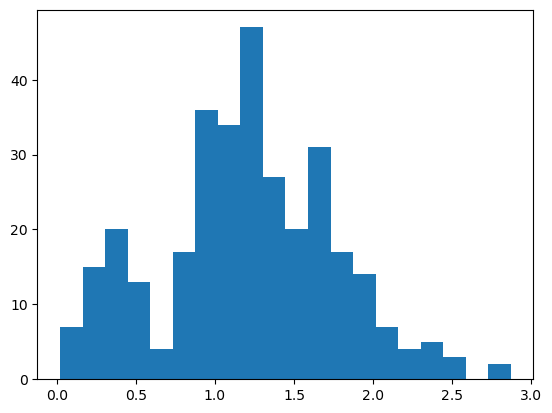

In [127]:
plt.hist(ddg,bins=20)

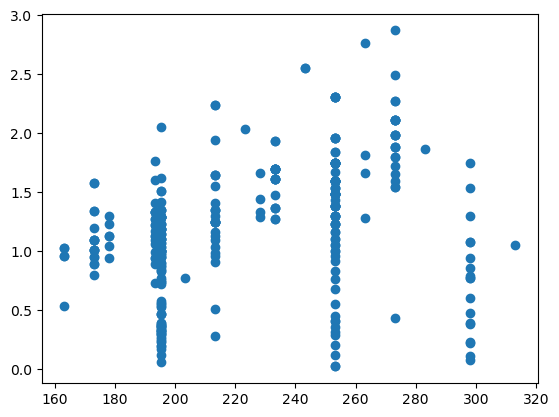

In [128]:
plt.scatter(alldesc["Temperature (Kelvin)"],ddg)


# 6. Modelling - Test of different frameworks

R² Score: 0.573
Mean Squared Error: 0.123
Mean Absolute Error: 0.251


(0.0, 3.0)

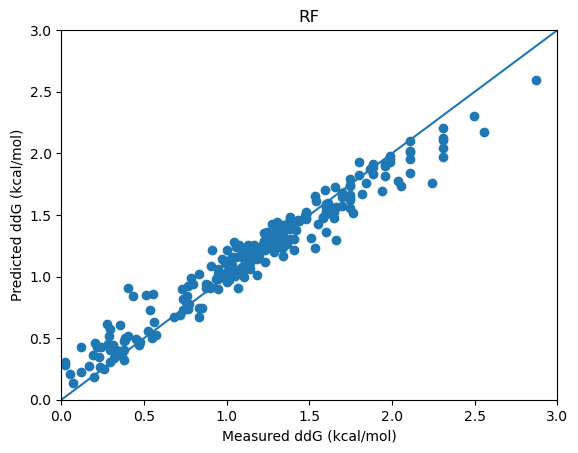

In [139]:
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold

regressor = RandomForestRegressor( n_estimators=200).fit(xtrainscaled, ytrain)
ypred = regressor.predict(xtrainscaled)
cv = KFold(n_splits=10, shuffle=True, random_state=42)

# Perform cross-validation predictions
ypred_cv = cross_val_predict(regressor, xtrainscaled, ytrain, cv=cv)

# Cross-validated R2 score, MSE, and MAE
scores_r2 = cross_val_score(regressor, xtrainscaled, ytrain, scoring='r2', cv=cv)
scores_mse = cross_val_score(regressor, xtrainscaled, ytrain, scoring='neg_mean_squared_error', cv=cv)
scores_mae = cross_val_score(regressor, xtrainscaled, ytrain, scoring='neg_mean_absolute_error', cv=cv)

# Average scores for reporting
r2_average = np.mean(scores_r2)
mse_average = -np.mean(scores_mse)  # Note the negation because scores return negative values for loss
mae_average = -np.mean(scores_mae)  # Note the negation for the same reason
print(f'R² Score: {r2_average:.3f}')
print(f'Mean Squared Error: {mse_average:.3f}')
print(f'Mean Absolute Error: {mae_average:.3f}')

plt.scatter(ytrain, ypred)
plt.xlabel('Measured ddG (kcal/mol)')
plt.ylabel('Predicted ddG (kcal/mol)')
plt.title('RF')
plt.xlim([0,3])
plt.plot([0,3],[0,3])
plt.ylim([0,3])


R² Score: 0.582
Mean Squared Error: 0.122
Mean Absolute Error: 0.260


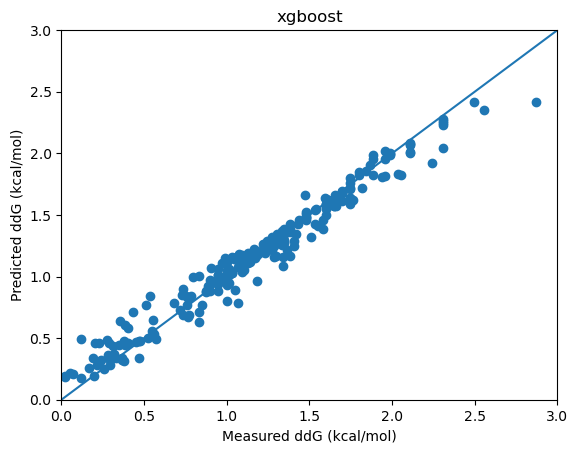

In [148]:
import xgboost as xgb

xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', n_estimators=500, learning_rate=0.02, max_depth=8, alpha=1.0)

# Fit the model to the training data
xg_reg.fit(xtrainscaled, ytrain)

# Predict on the test set
ypred = xg_reg.predict(xtrainscaled)
# Evaluate the model
plt.scatter(ytrain, ypred)
plt.xlabel('Measured ddG (kcal/mol)')
plt.xlim([0,3])
plt.plot([-3,3],[-3,3])
plt.ylim([0,3])
plt.ylabel('Predicted ddG (kcal/mol)')
plt.title('xgboost')
cv = KFold(n_splits=10, shuffle=True, random_state=40)

# Perform cross-validation predictions
ypred_cv = cross_val_predict(xg_reg, xtrainscaled, ytrain, cv=cv)

# Cross-validated R2 score, MSE, and MAE
scores_r2 = cross_val_score(xg_reg, xtrainscaled, ytrain, scoring='r2', cv=cv)
scores_mse = cross_val_score(xg_reg, xtrainscaled, ytrain, scoring='neg_mean_squared_error', cv=cv)
scores_mae = cross_val_score(xg_reg, xtrainscaled, ytrain, scoring='neg_mean_absolute_error', cv=cv)

# Average scores for reporting
r2_average = np.mean(scores_r2)
mse_average = -np.mean(scores_mse)  # Note the negation because scores return negative values for loss
mae_average = -np.mean(scores_mae)  # Note the negation for the same reason
print(f'R² Score: {r2_average:.3f}')
print(f'Mean Squared Error: {mse_average:.3f}')
print(f'Mean Absolute Error: {mae_average:.3f}')

R² Score: 0.505
Mean Squared Error: 0.144
Mean Absolute Error: 0.277


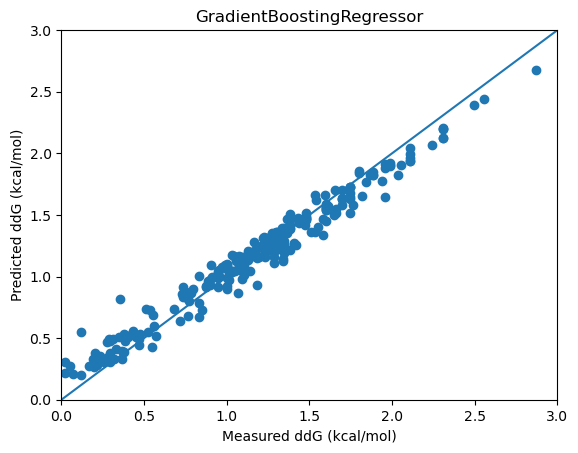

In [131]:
from sklearn.ensemble import GradientBoostingRegressor


# Create a GradientBoostingRegressor
gb_reg = GradientBoostingRegressor(n_estimators=100, learning_rate=0.03, max_depth=5, random_state=42)

# Fit the model to the training data
gb_reg.fit(xtrainscaled, ytrain)
ypred = gb_reg.predict(xtrainscaled)
# Evaluate the model
plt.scatter(ytrain, ypred)
plt.xlabel('Measured ddG (kcal/mol)')
plt.xlim([0,3])
plt.plot([-3,3],[-3,3])
plt.ylim([0,3])
plt.ylabel('Predicted ddG (kcal/mol)')
plt.title('GradientBoostingRegressor')
cv = KFold(n_splits=10, shuffle=True, random_state=4)

# Perform cross-validation predictions
ypred_cv = cross_val_predict(gb_reg, xtrainscaled, ytrain, cv=cv)

# Cross-validated R2 score, MSE, and MAE
scores_r2 = cross_val_score(gb_reg, xtrainscaled, ytrain, scoring='r2', cv=cv)
scores_mse = cross_val_score(gb_reg, xtrainscaled, ytrain, scoring='neg_mean_squared_error', cv=cv)
scores_mae = cross_val_score(gb_reg, xtrainscaled, ytrain, scoring='neg_mean_absolute_error', cv=cv)

# Average scores for reporting
r2_average = np.mean(scores_r2)
mse_average = -np.mean(scores_mse)  # Note the negation because scores return negative values for loss
mae_average = -np.mean(scores_mae)  # Note the negation for the same reason
print(f'R² Score: {r2_average:.3f}')
print(f'Mean Squared Error: {mse_average:.3f}')
print(f'Mean Absolute Error: {mae_average:.3f}')

R² Score: 0.458
Mean Squared Error: 0.157
Mean Absolute Error: 0.296


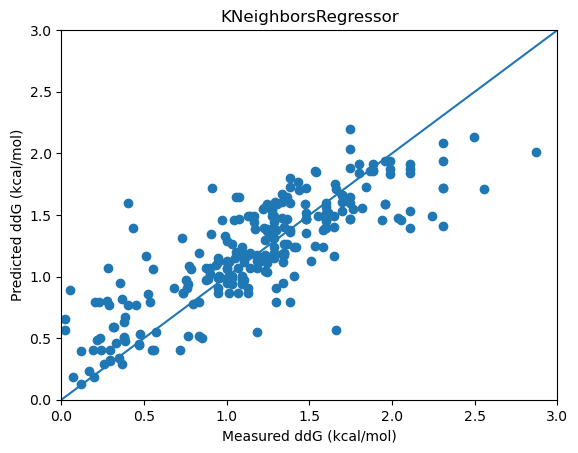

In [150]:
from sklearn.neighbors import KNeighborsRegressor

knn_regressor = KNeighborsRegressor(n_neighbors=5,weights='uniform', algorithm='auto')  # You can adjust the number of neighbors (k) based on your preference

# Fit the model
knn_regressor.fit(xtrainscaled, ytrain)

# Make predictions on the test set
ypred = knn_regressor.predict(xtrainscaled)
# Evaluate the model
plt.scatter(ytrain, ypred)
plt.xlabel('Measured ddG (kcal/mol)')
plt.xlim([0,3])
plt.plot([-3,3],[-3,3])
plt.ylim([0,3])
plt.ylabel('Predicted ddG (kcal/mol)')
plt.title('KNeighborsRegressor')
cv = KFold(n_splits=10, shuffle=True, random_state=42)

# Perform cross-validation predictions
ypred_cv = cross_val_predict(knn_regressor, xtrainscaled, ytrain, cv=cv)

# Cross-validated R2 score, MSE, and MAE
scores_r2 = cross_val_score(knn_regressor, xtrainscaled, ytrain, scoring='r2', cv=cv)
scores_mse = cross_val_score(knn_regressor, xtrainscaled, ytrain, scoring='neg_mean_squared_error', cv=cv)
scores_mae = cross_val_score(knn_regressor, xtrainscaled, ytrain, scoring='neg_mean_absolute_error', cv=cv)

# Average scores for reporting
r2_average = np.mean(scores_r2)
mse_average = -np.mean(scores_mse)  # Note the negation because scores return negative values for loss
mae_average = -np.mean(scores_mae)  # Note the negation for the same reason
print(f'R² Score: {r2_average:.3f}')
print(f'Mean Squared Error: {mse_average:.3f}')
print(f'Mean Absolute Error: {mae_average:.3f}')

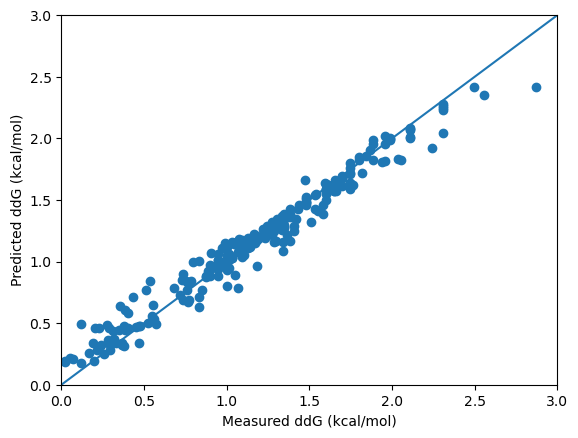

R² Score: 0.493
Mean Squared Error: 0.140
Mean Absolute Error: 0.275


In [149]:
from sklearn.pipeline import Pipeline

# Initialize the XGBoost regressor
xg_reg_initial = xgb.XGBRegressor(objective ='reg:squarederror', n_estimators=500, learning_rate=0.02, max_depth=8, alpha=1.0)
# Configure Recursive Feature Elimination
rfe = RFE(estimator=xg_reg_initial, n_features_to_select=35)  # Adjust the number of features as needed

xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', n_estimators=500, learning_rate=0.02, max_depth=8, alpha=1.0)


# Create a pipeline with RFE and XGBoost Regressor
pipeline = Pipeline([
    ('feature_selection', rfe),
    ('regressor', xg_reg)
])

# Define the cross-validation strategy
cv = KFold(n_splits=10, shuffle=True, random_state=2)
# Perform cross-validation predictions
ypred_cv = cross_val_predict(pipeline, xtrainscaled, ytrain, cv=cv)

# Cross-validated R2 score, MSE, and MAE
scores_r2 = cross_val_score(pipeline, xtrainscaled, ytrain, scoring='r2', cv=cv)
scores_mse = cross_val_score(pipeline, xtrainscaled, ytrain, scoring='neg_mean_squared_error', cv=cv)
scores_mae = cross_val_score(pipeline, xtrainscaled, ytrain, scoring='neg_mean_absolute_error', cv=cv)

# Average scores for reporting
r2_average = np.mean(scores_r2)
mse_average = -np.mean(scores_mse)  # Note the negation because scores return negative values for loss
mae_average = -np.mean(scores_mae)  # Note the negation for the same reason

# Plotting the results
plt.scatter(ytrain, ypred)
plt.xlabel('Measured ddG (kcal/mol)')
plt.xlim([0,3])
plt.plot([-3,3],[-3,3])
plt.ylim([0,3])
plt.ylabel('Predicted ddG (kcal/mol)')
plt.show()
print(f'R² Score: {r2_average:.3f}')
print(f'Mean Squared Error: {mse_average:.3f}')
print(f'Mean Absolute Error: {mae_average:.3f}')

# 8. Hyperparameter Optimization and LOO CV

In [179]:
n_estimators = range(20,900)
max_depth = range(1,10)
min_samples_split = range(1,10)
min_samples_leaf = range(1,10)

random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               }

In [180]:
regressor = RandomForestRegressor()

rf_random = RandomizedSearchCV(estimator = regressor, param_distributions = random_grid, cv=10, n_iter=100,scoring='r2', random_state=42)
rf_random.fit(xtrain, ytrain)
print(rf_random.best_params_)


/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
100 fits failed out of a total of 1000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
100 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py", line 340, in fit
    self._validate_params()
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/opt/anaconda3/lib/python3.11/sit

{'n_estimators': 366, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 8}


In [181]:
from sklearn.model_selection import LeaveOneOut
scorer = make_scorer(mean_absolute_error, greater_is_better=False)

best_estimator =  rf_random.best_estimator_
cv_strategy = LeaveOneOut()  
mae_scores = -cross_val_score(best_estimator, xtrainscaled, ytrain,  cv=cv_strategy,scoring=scorer)

# Calculate mean MAE
mae_mean = np.mean(mae_scores)

print("Mean Absolute Error (MAE) using LOO Cross-Validation:", mae_mean)

Mean Absolute Error (MAE) using LOO Cross-Validation: 0.2559926988506388


**Conclusions**


The results from cross-validation of the above models are insufficient for our predictive models to construct a credible virtual dataset. These shortcomings are likely due to overfitting and regression to the mean. Therefore, we determined that the best course of action was to take a step back and focus on obtaining more chemically relevant parameters.


Given the high selectivity associated with IDPIs, which is typically attributed to structural confinement, we initially focused on collecting parameters related to catalyst side group geometry, size, steric effects, and other potentially influential factors. Additionally, we gathered parameters connected to the accessibility of reaction sites in electrophiles and nucleophiles, while retaining some of the more relevant descriptors from RDKit for both substrates and catalysts. Finally, we explored the inclusion of information on the chemical neighbourhood for substrates derived from CSN.

Additionally, to combat the observed problems with overfitting, we opted to utilize the **XGBoost algorithm** along with **Recursive Feature Elimination (RFE)** for the following reasons:
- **Utilize regularization techniques** of XGBoost to enhance model robustness.
- **Limit the dimensionality** of our dataset to combat the "Curse of Dimensionality".

Both strategies were implemented to avoid overfitting, which is a common concern in datasets like ours and its evidence can be seen in some of the plots presented above, as our model struggles to generalize.
